In [1]:
#relevant imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from skimage import io
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch.utils.data as data
import torchvision.utils as vutils
from torchinfo import summary
import torch.nn.functional as F





This notebook aims to implement hybrid CNN models for detection of breast cancer as proposed by Sahu et al in their paper *High accuracy hybrid CNN classifiers for breast cancer detection using mammogram and ultrasound datasets*

# Initial Exploratory analysis

In [2]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info['label'] = fold_info['label'].map({'malignant': 1, 'benign': 0})
fold_info[1:]

fold  mag    grp                                           filename  \
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
5         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
...     ...  ...    ...                                                ...   
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   

       label  
1          0  
2          0  
3          0  
4          0  
5          0  
...      ...  
39540      1  
39541      1  
39542      1  
39543      1  
39544      1  

[39544 rows x 5 columns]

For the extent of this implementation, I will be focusing on 2-fold images, and all work would be done on them.

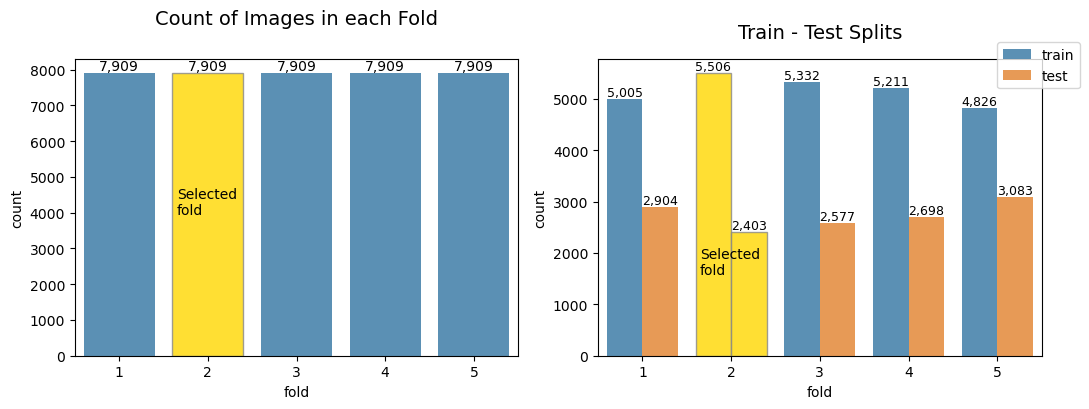

In [3]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy()
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

# Plot image count in each fold
sns.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=0,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 2,
         "Selected\nfold")
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sns.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 5,
         "Selected\nfold")
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

In [4]:
selected_fold_data['label'].value_counts()

1    5429
0    2480
Name: label, dtype: int64

In [5]:
train = selected_fold_data.query("grp == 'train'")
test = selected_fold_data.query("grp == 'test'")
train.shape, test.shape

((5506, 5), (2403, 5))

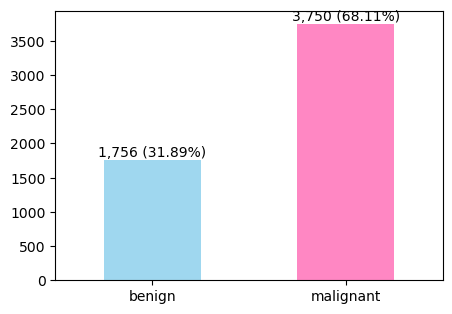

In [6]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=0,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

As we can see that the classes are quite imbalanced. To deal with this, a weighted loss function can be used, but for the scope of this project, I will undersample the dataset, taking 1500 both images from both classes. This will help the model train quicker as well.
Doing so will upset the train-test split. To counter that, we will undersample the test set as well but without touching the class imbalance. This is done to maintain the real-world nature of the data. A split of 75:25 is maintained.

In [7]:
benign_df=train[train["label"]==0]
mal_df=train[train["label"]==1]
benign_sample=benign_df.sample(n=1500, random_state=42)
mal_sample=mal_df.sample(n=1500, random_state=42)
train_balanced=pd.concat([benign_sample, mal_sample])

test_set=test.sample(n=500, random_state=42)
train_balanced.shape, test_set.shape

((3000, 5), (500, 5))

In [8]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

# Handling the data

In [9]:
class CustomDataset(data.Dataset):
    '''
    Implementation of a custom dataset class.
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['filename']
        label = self.df.iloc[index]['label']
        img = Image.open(filename).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)


In [10]:
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_SIZE=224
BATCH_SIZE=64

In [11]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.Normalize(MEAN, STD)
    
])

In [12]:
#creating relevant dataloaders

train_dataset = CustomDataset(train_balanced, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_set, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
next(iter(test_loader))[0].shape

torch.Size([64, 3, 224, 224])

In [14]:
len(train_dataset), len(test_dataset)

(3000, 500)

In [15]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()


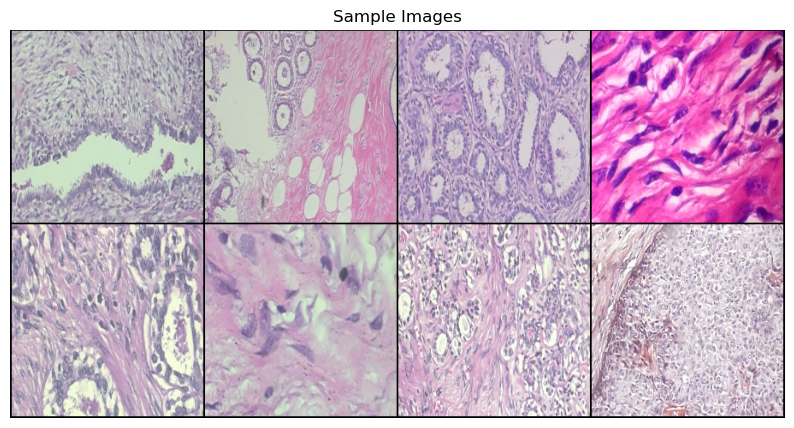

In [16]:
plot_images(train_loader, num_images=8)

In [17]:
class SaveBestModel:
    """ class to save best model while training. """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/best_model.pth')



In [18]:
def save_model(epochs, model, optimizer, loss_fn):
    """
    save final model
    """
    print(f"Saving final model.")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/final_model.pth')

In [19]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, num):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/accuracy_h{num}.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/loss_h{num}.png")

# Defining model classes.

The classes for all four models used in the paper in various combinations are defined, namely: 
- MobileNetV2 
- ResNet18
- ShuffleNet
- VGG16

Along with that, the weight factor function is defined as well.

In [20]:
class ResNet18(nn.Module):
    '''
    Class to define a finetuned ResNet18 model. 
    Args:
        num_classes: number of classes
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs * 2),
            nn.Linear(num_ftrs * 2, num_classes))

    def forward(self, x):
        return self.resnet18(x)


In [21]:
class ShuffleNet(nn.Module):
    """
    Class to define a finetuned shufflenet model.
    args:
        num_classes: number of classes
    """
    def __init__(self, num_classes):
        super().__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        self.num_classes = num_classes
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.shufflenet.conv1(x)
        x = self.shufflenet.maxpool(x)
        x = self.shufflenet.stage2(x)
        x = self.shufflenet.stage3(x)
        x = self.shufflenet.stage4(x)
        x = self.shufflenet.conv5(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x



In [22]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze the feature extraction layers
        for param in self.vgg16.features.parameters():
            param.requires_grad = False
        
        # Replace the last fully connected layer with a new one
        num_features = self.vgg16.classifier[-1].in_features
        self.vgg16.classifier[-1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x


In [23]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load the pre-trained MobileNetV2 model
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        
        # Replace the last fully connected layer with a new one
        num_features = self.mobilenetv2.classifier[-1].in_features
        self.mobilenetv2.classifier[-1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.mobilenetv2(x)
        return x



In [24]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load the pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)

        # Replace the last fully connected layer with a new one
        num_features = self.alexnet.classifier[-1].in_features
        self.alexnet.classifier[-1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return x


In [25]:
B=0.05 #threshold value to determine the activation of second model

def weight_factor(class_prob):
    """
    function to calculate weight factor as defined in the paper.
    args:
        class_prob: pytorch tensor with dims [batch_size, 2]
    """
    p1 = class_prob[:, 0]
    p2 = class_prob[:, 1]
    w = torch.abs(torch.mul(p1, torch.log2(2 * p2)) + torch.mul(p2, torch.log2(2 * p1)))
    return w

# Setting up test and train functions

In [26]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """
    One epoch of training.
    Args:
        model: the pytorch model to be trained
        dataloader: pytorch DataLoader object to train the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        device: gpu/cpu
    """
 
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) :
    """
    One epoch of testing.
    Args:
        model: the pytorch model to be tested
        dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        device: gpu/cpu
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, recall, precision, specificity, f1, auc = 0, 0, 0, 0, 0, 0 ,0

    #Create lists to store indices for subset creation
    selected_batch_indices = []
    selected_sample_indices = []
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            #get class probabilities and subsequently weight factor
            class_prob=F.softmax(test_pred_logits, dim=1)
            weights=weight_factor(class_prob)
            
            #sending logits to cpu for metrics calculation
            y_cpu=y.detach().cpu().numpy()
            y_pred_cpu=test_pred_logits.detach().cpu().numpy()
            y_pred_bin = np.argmax(y_pred_cpu, axis=1)
            

            #store indices of images with weight factor less than threshold to access labels
            selected_sample_indices_batch = [i for i, w in enumerate(weights) if w < B]
            selected_batch_indices += [batch] * len(selected_sample_indices_batch)
            selected_sample_indices += selected_sample_indices_batch

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
    

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
            #calculation of metrics
            precision+=precision_score(y_cpu, y_pred_bin)
            recall+=recall_score(y_cpu, y_pred_bin)
            f1+=f1_score(y_cpu, y_pred_bin)
            auc+=roc_auc_score(y_cpu, y_pred_bin)
            specificity+=recall_score(y_cpu, y_pred_bin, pos_label=0)
            



    
    #create a subset of the relevant images and add their labels
    selected_indices = [i * BATCH_SIZE + j for i, j in zip(selected_batch_indices, selected_sample_indices)]
    epoch_subset = Subset(test_dataset, selected_indices)
    
    #get avg metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    precision=precision/len(test_loader)*100 #percentage
    recall=recall/len(test_loader)*100 #percentage
    auc=auc/len(test_loader)
    f1=f1/len(test_loader)
    specificity=specificity/len(test_loader)*100 #percentage

    
    return test_loss, test_acc, epoch_subset, weights, precision, recall, auc, f1, specificity
    

In [28]:

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, num) :
    """
    Joint train and test step.
    Args:
        model: the pytorch model to be trained
        train_dataloader: pytorch DataLoader object to train the model on
        test_dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        epochs: number of epochs 
        device: gpu/cpu
        num: hybrid number, used for saving plots
  
    """
 
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    
    
    final_subset=[]
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc , epoch_subset, weights,precision, recall, auc, f1, specificity = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc %: {test_acc*100:.2f} | "
            f"precision %: {precision:.2f} | "
            f"recall %: {recall: .2f} | "
            f"auc : {auc :.4f} | "
            f"specificity %: {specificity:.2f} | "
            f"f1: {f1:.4f} "
    
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
#         results["class_prob"].append(class_prob)
        final_subset=epoch_subset
#         save_best_model(test_loss, epoch, model, optimizer, loss_fn)

#     save_model(epochs, model,optimizer, loss_fn)
    save_plots(results["train_acc"], results["test_acc"], results["train_loss"], results["test_loss"], num)

    # Return the filled results and subset at the end of the epochs
    return results, final_subset, weights

# Defining and training hybrid models.

# HYBRID 1 : MobileNetV2 + ResNet18

In [29]:
mobilenet_h1 = MobileNetV2(num_classes=2)


mobilenet_h1_opt=torch.optim.SGD(params=mobilenet_h1.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [30]:
resnet_h1 = ResNet18(num_classes=2)
resnet_h1_opt=torch.optim.Adam(params=resnet_h1.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6478 | train_acc: 0.6244 | test_loss: 0.5539 | test_acc %: 79.64 | precision %: 88.20 | recall %:  80.50 | auc : 0.7895 | specificity %: 77.41 | f1: 0.8414 
Epoch: 2 | train_loss: 0.4953 | train_acc: 0.8050 | test_loss: 0.4766 | test_acc %: 81.78 | precision %: 89.12 | recall %:  83.13 | auc : 0.8106 | specificity %: 79.00 | f1: 0.8598 
Epoch: 3 | train_loss: 0.4042 | train_acc: 0.8477 | test_loss: 0.4251 | test_acc %: 81.78 | precision %: 88.70 | recall %:  83.79 | auc : 0.8086 | specificity %: 77.93 | f1: 0.8610 
Epoch: 4 | train_loss: 0.3469 | train_acc: 0.8711 | test_loss: 0.3882 | test_acc %: 84.60 | precision %: 89.25 | recall %:  87.92 | auc : 0.8288 | specificity %: 77.85 | f1: 0.8847 
Epoch: 5 | train_loss: 0.3133 | train_acc: 0.8765 | test_loss: 0.3827 | test_acc %: 82.80 | precision %: 89.91 | recall %:  84.14 | auc : 0.8220 | specificity %: 80.25 | f1: 0.8680 
Epoch: 6 | train_loss: 0.2755 | train_acc: 0.8961 | test_loss: 0.3665 | test_acc %: 84.84 

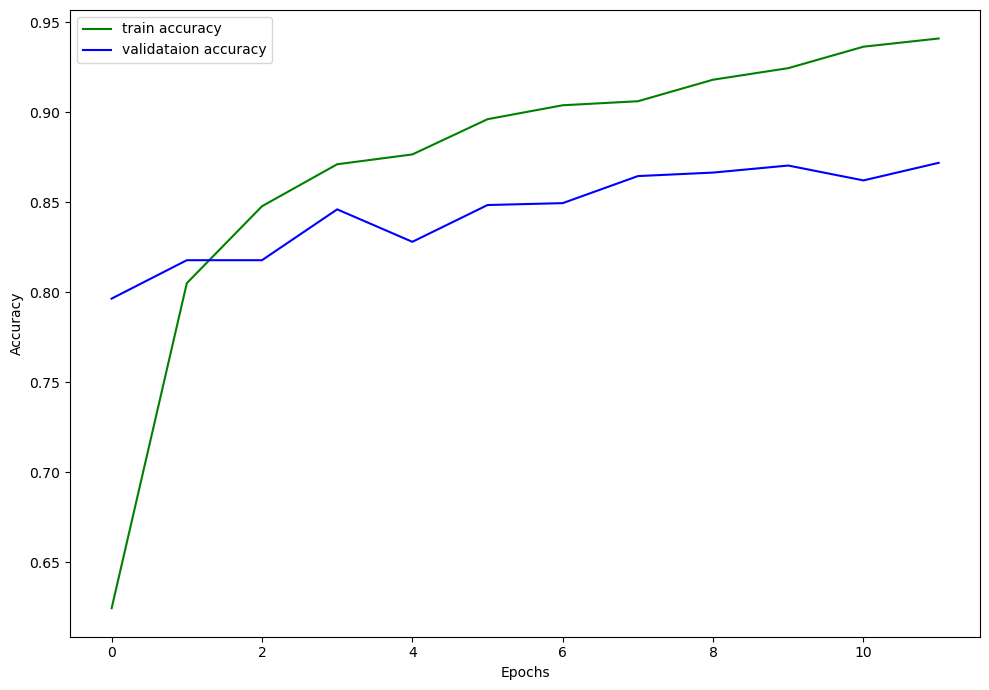

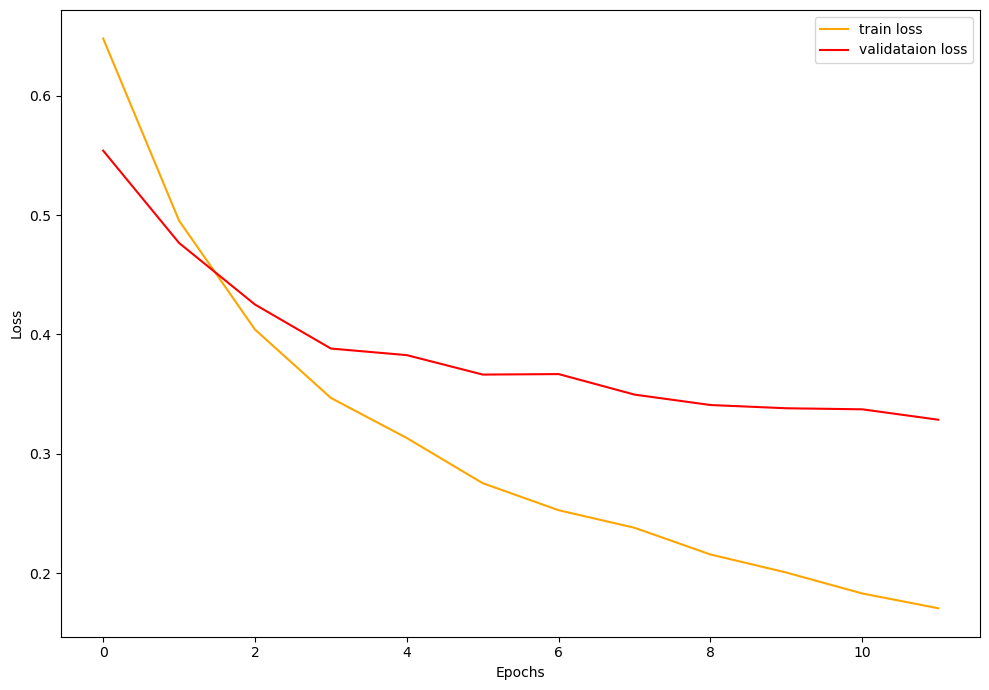

In [31]:
results, final_subset, weights=train(model=mobilenet_h1,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=mobilenet_h1_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=10)

final_subset is a subset of the test set whose B value is less than the threshold. These images will be passed on to training from the second model, thus activating the hybrid architecture.
A dataloader is created for final_subset and the second model is tested against it. The training of the secomd model is done on the train_dataset as well.

In [32]:
len(final_subset)

25

In [33]:
hybrid_loader1 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

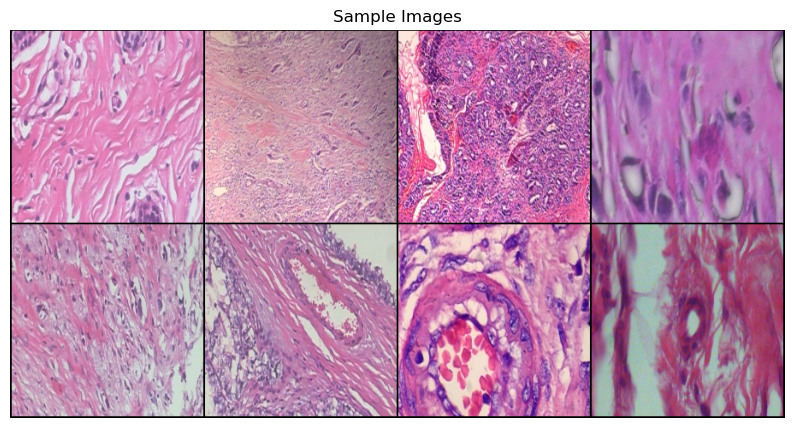

In [34]:
plot_images(hybrid_loader1, 8)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4718 | train_acc: 0.7955 | test_loss: 0.7044 | test_acc %: 56.00 | precision %: 10.29 | recall %:  7.95 | auc : 0.0398 | specificity %: 0.00 | f1: 0.0897 
Epoch: 2 | train_loss: 0.2432 | train_acc: 0.9231 | test_loss: 0.5379 | test_acc %: 80.00 | precision %: 11.31 | recall %:  10.80 | auc : 0.0748 | specificity %: 4.17 | f1: 0.1105 
Epoch: 3 | train_loss: 0.1465 | train_acc: 0.9580 | test_loss: 0.9608 | test_acc %: 40.00 | precision %: 12.50 | recall %:  3.98 | auc : 0.0824 | specificity %: 12.50 | f1: 0.0603 
Epoch: 4 | train_loss: 0.1055 | train_acc: 0.9683 | test_loss: 0.7835 | test_acc %: 56.00 | precision %: 11.54 | recall %:  6.82 | auc : 0.0758 | specificity %: 8.33 | f1: 0.0857 
Epoch: 5 | train_loss: 0.0761 | train_acc: 0.9804 | test_loss: 1.0734 | test_acc %: 44.00 | precision %: 10.42 | recall %:  5.68 | auc : 0.0492 | specificity %: 4.17 | f1: 0.0735 
Epoch: 6 | train_loss: 0.0789 | train_acc: 0.9793 | test_loss: 1.0542 | test_acc %: 48.00 | precis

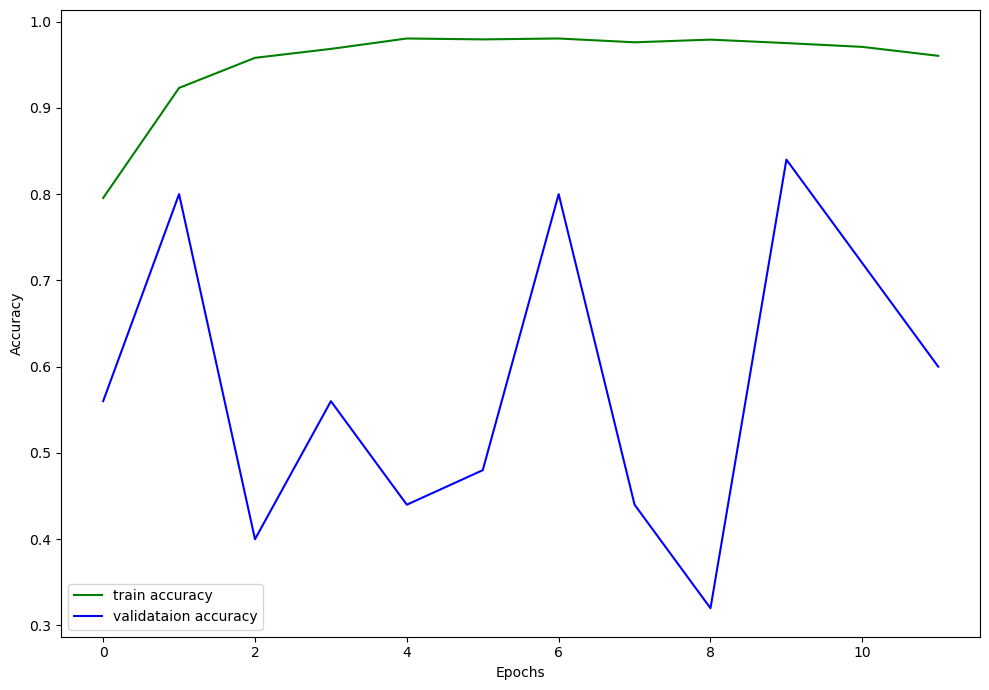

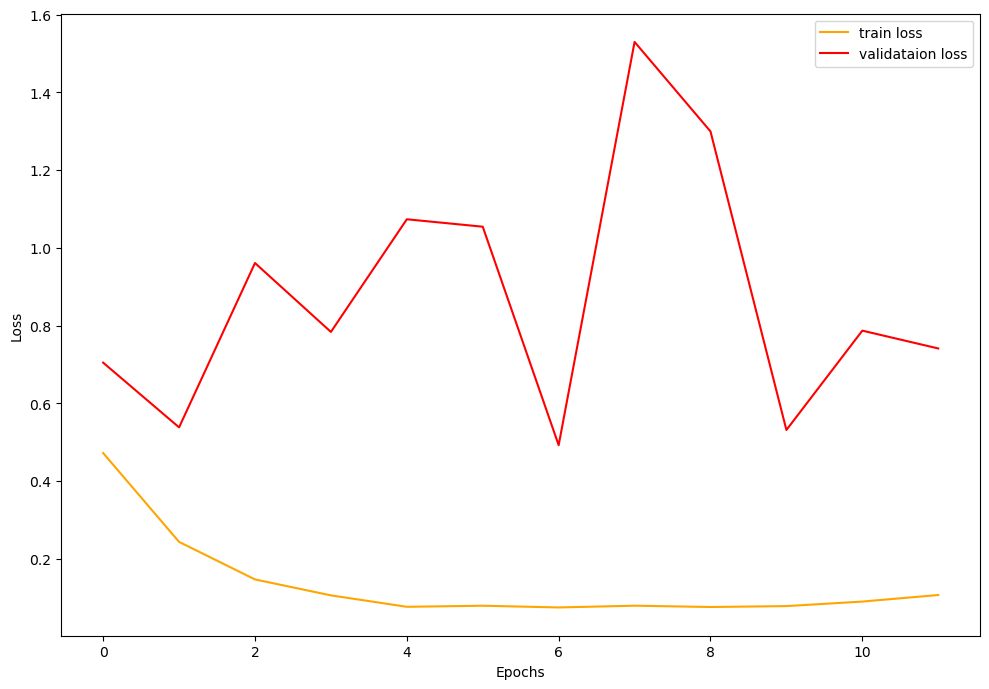

In [35]:
results, final_subset, weights=train(model=resnet_h1,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader1,
              optimizer=resnet_h1_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=11 )

--------------

# HYBRID 2 : VGG16 + ResNet18

In [36]:
vgg_h2=VGG16(num_classes=2)
vgg_h2_opt=torch.optim.Adam(params=vgg_h2.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

# save_best_model=SaveBestModel()


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [37]:
resnet_h2 = ResNet18(num_classes=2)
resnet_h2_opt=torch.optim.Adam(params=resnet_h2.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5336 | train_acc: 0.7331 | test_loss: 0.4700 | test_acc %: 81.39 | precision %: 80.11 | recall %:  96.34 | auc : 0.7377 | specificity %: 51.20 | f1: 0.8737 
Epoch: 2 | train_loss: 0.4425 | train_acc: 0.8037 | test_loss: 0.4686 | test_acc %: 80.32 | precision %: 87.11 | recall %:  83.11 | auc : 0.7860 | specificity %: 74.10 | f1: 0.8494 
Epoch: 3 | train_loss: 0.4027 | train_acc: 0.8281 | test_loss: 0.4850 | test_acc %: 79.54 | precision %: 89.21 | recall %:  79.20 | auc : 0.7951 | specificity %: 79.82 | f1: 0.8378 
Epoch: 4 | train_loss: 0.3860 | train_acc: 0.8407 | test_loss: 0.4356 | test_acc %: 81.84 | precision %: 86.05 | recall %:  87.15 | auc : 0.7883 | specificity %: 70.51 | f1: 0.8648 
Epoch: 5 | train_loss: 0.3890 | train_acc: 0.8431 | test_loss: 0.5242 | test_acc %: 73.50 | precision %: 88.16 | recall %:  70.23 | auc : 0.7489 | specificity %: 79.56 | f1: 0.7797 
Epoch: 6 | train_loss: 0.3934 | train_acc: 0.8324 | test_loss: 0.4413 | test_acc %: 81.73 

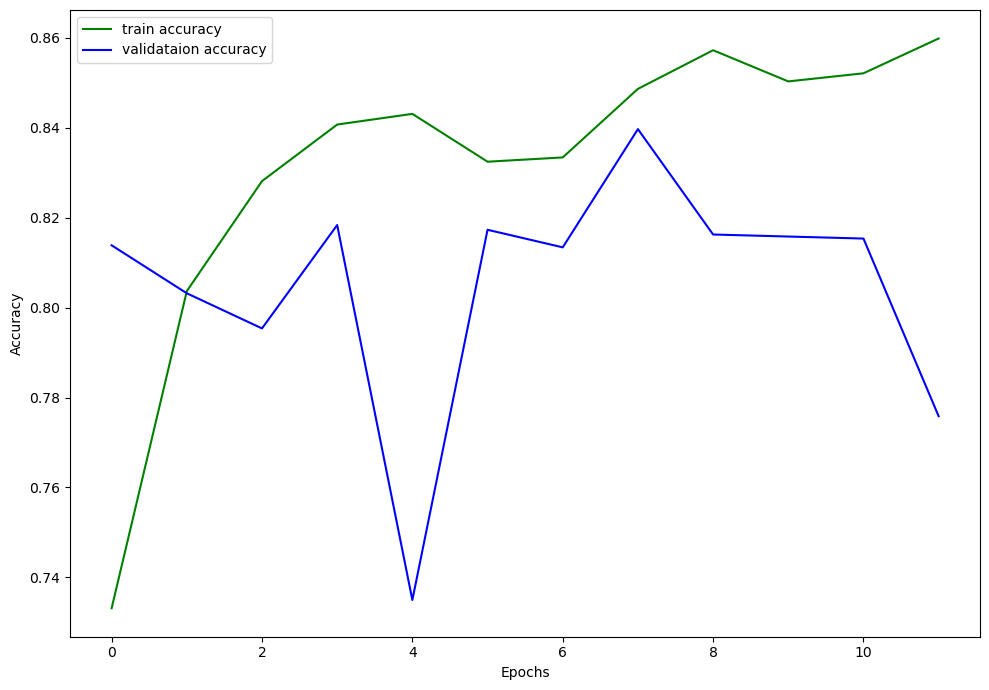

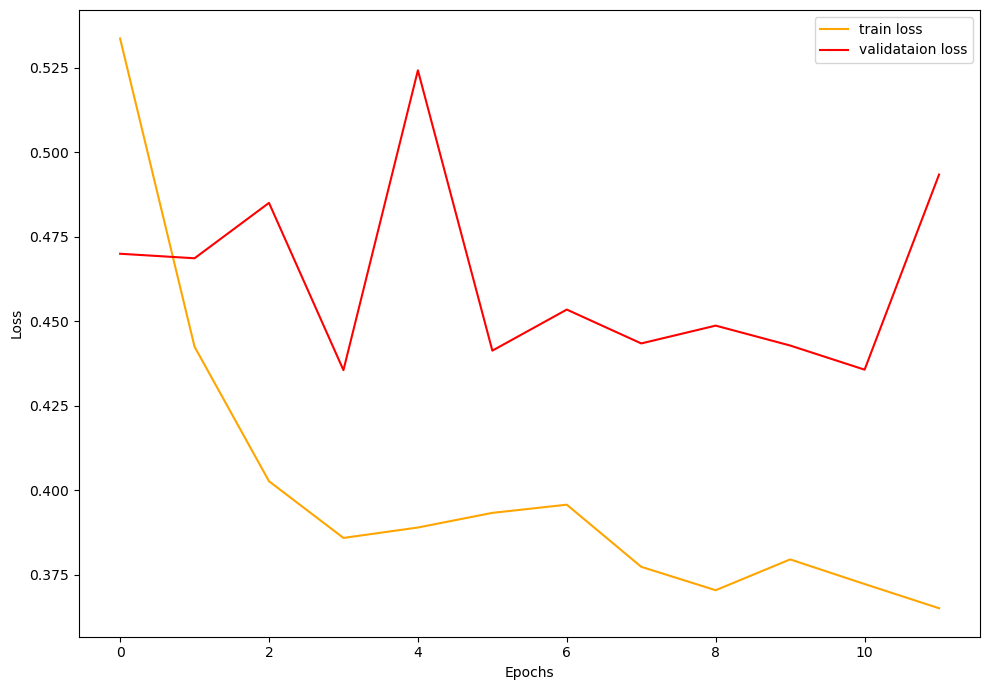

In [38]:
results, final_subset, weights=train(model=vgg_h2,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=vgg_h2_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device , num=21)

In [39]:
hybrid_loader2 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

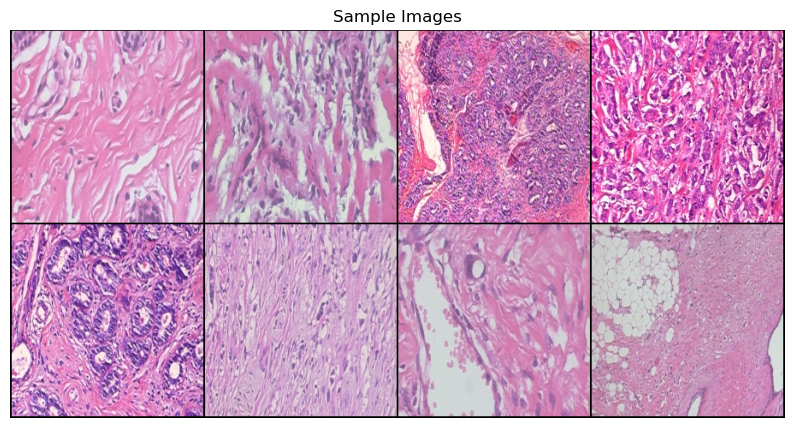

In [40]:
plot_images(hybrid_loader2, 8)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4748 | train_acc: 0.7978 | test_loss: 0.7331 | test_acc %: 60.00 | precision %: 11.61 | recall %:  7.39 | auc : 0.0786 | specificity %: 8.33 | f1: 0.0903 
Epoch: 2 | train_loss: 0.2534 | train_acc: 0.9114 | test_loss: 0.7384 | test_acc %: 48.00 | precision %: 11.36 | recall %:  5.68 | auc : 0.0701 | specificity %: 8.33 | f1: 0.0758 
Epoch: 3 | train_loss: 0.1446 | train_acc: 0.9640 | test_loss: 0.9690 | test_acc %: 40.00 | precision %: 11.11 | recall %:  4.55 | auc : 0.0644 | specificity %: 8.33 | f1: 0.0645 
Epoch: 4 | train_loss: 0.1061 | train_acc: 0.9687 | test_loss: 0.8630 | test_acc %: 44.00 | precision %: 11.25 | recall %:  5.11 | auc : 0.0672 | specificity %: 8.33 | f1: 0.0703 
Epoch: 5 | train_loss: 0.0707 | train_acc: 0.9794 | test_loss: 0.5797 | test_acc %: 64.00 | precision %: 12.50 | recall %:  7.39 | auc : 0.0994 | specificity %: 12.50 | f1: 0.0929 
Epoch: 6 | train_loss: 0.0573 | train_acc: 0.9843 | test_loss: 1.8464 | test_acc %: 36.00 | precisi

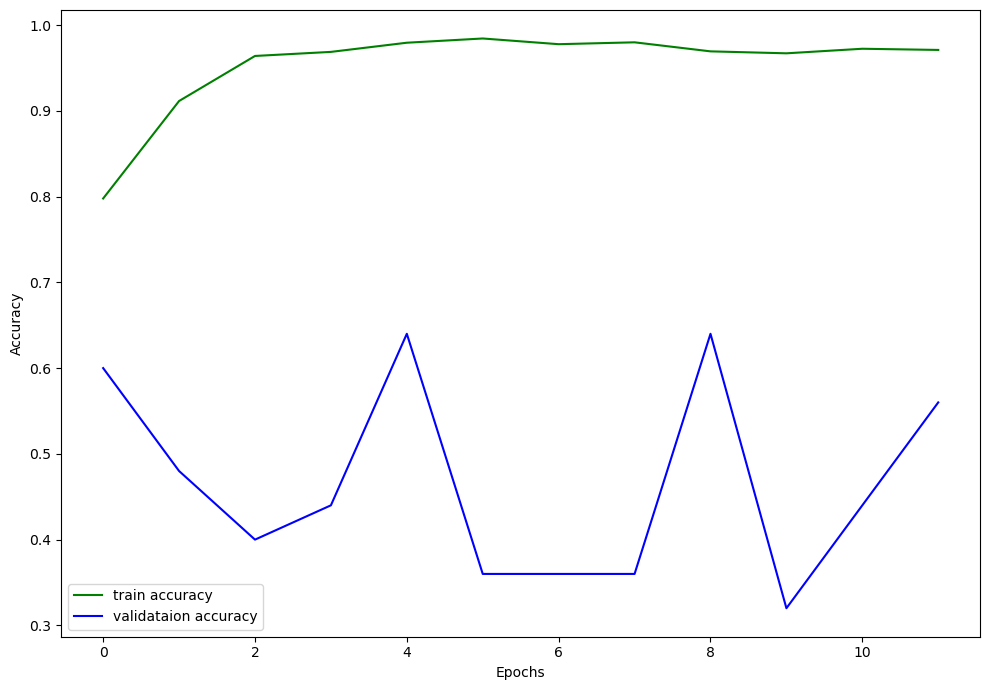

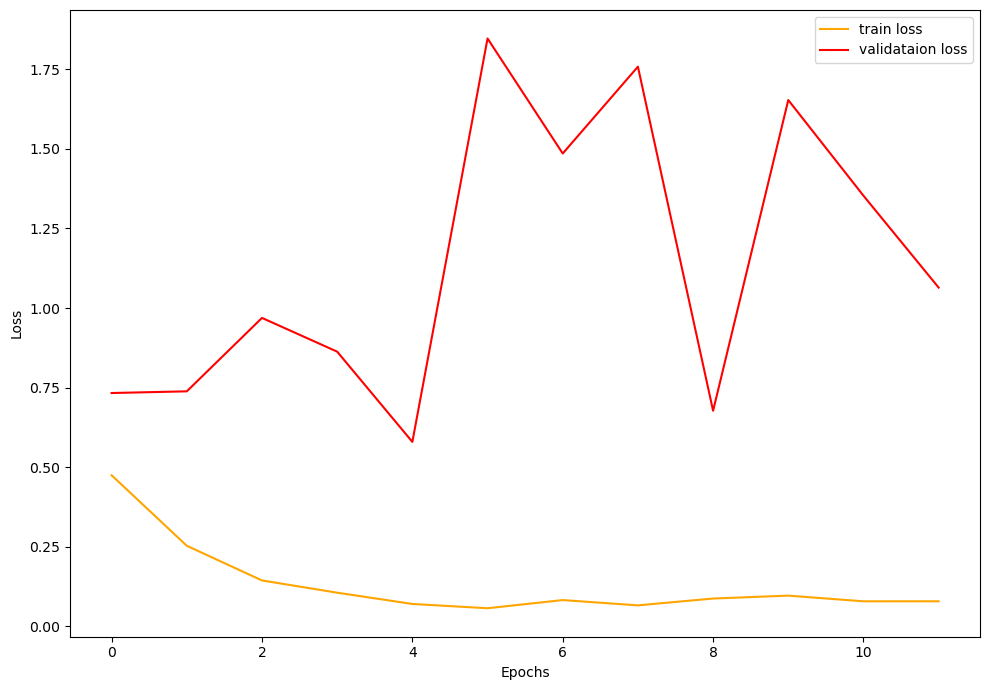

In [41]:
results, final_subset, weights=train(model=resnet_h2,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader1,
              optimizer=resnet_h2_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=22 )

------------------

# HYBRID 3 : ResNet18 + AlexNet

In [42]:
resnet_h3 = ResNet18(num_classes=2)
resnet_h3_opt=torch.optim.Adam(params=resnet_h3.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
alexnet_h3 = AlexNet(num_classes=2)



alexnet_h3_opt=torch.optim.SGD(params=alexnet_h3.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4707 | train_acc: 0.7966 | test_loss: 0.4637 | test_acc %: 79.82 | precision %: 90.31 | recall %:  78.32 | auc : 0.8069 | specificity %: 83.06 | f1: 0.8375 
Epoch: 2 | train_loss: 0.2433 | train_acc: 0.9240 | test_loss: 0.3407 | test_acc %: 86.99 | precision %: 91.42 | recall %:  88.95 | auc : 0.8584 | specificity %: 82.74 | f1: 0.9008 
Epoch: 3 | train_loss: 0.1337 | train_acc: 0.9680 | test_loss: 0.3322 | test_acc %: 86.45 | precision %: 91.03 | recall %:  88.41 | auc : 0.8541 | specificity %: 82.41 | f1: 0.8965 
Epoch: 4 | train_loss: 0.0952 | train_acc: 0.9706 | test_loss: 0.3539 | test_acc %: 86.64 | precision %: 89.91 | recall %:  90.41 | auc : 0.8458 | specificity %: 78.75 | f1: 0.9005 
Epoch: 5 | train_loss: 0.0713 | train_acc: 0.9801 | test_loss: 0.4077 | test_acc %: 82.51 | precision %: 86.67 | recall %:  87.32 | auc : 0.7995 | specificity %: 72.57 | f1: 0.8692 
Epoch: 6 | train_loss: 0.0650 | train_acc: 0.9840 | test_loss: 0.5367 | test_acc %: 80.17 

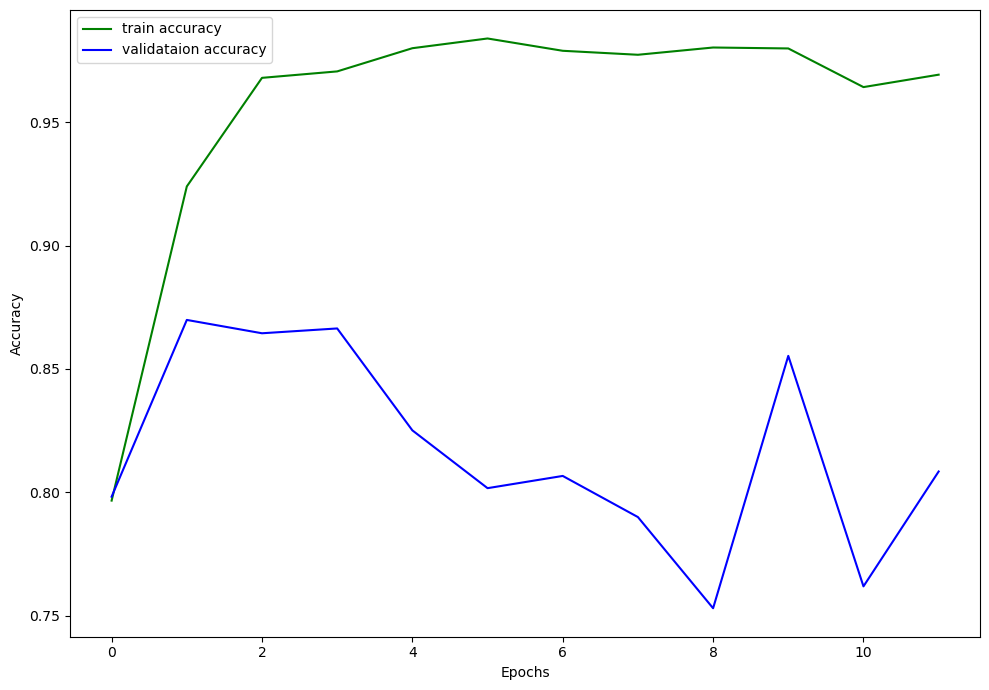

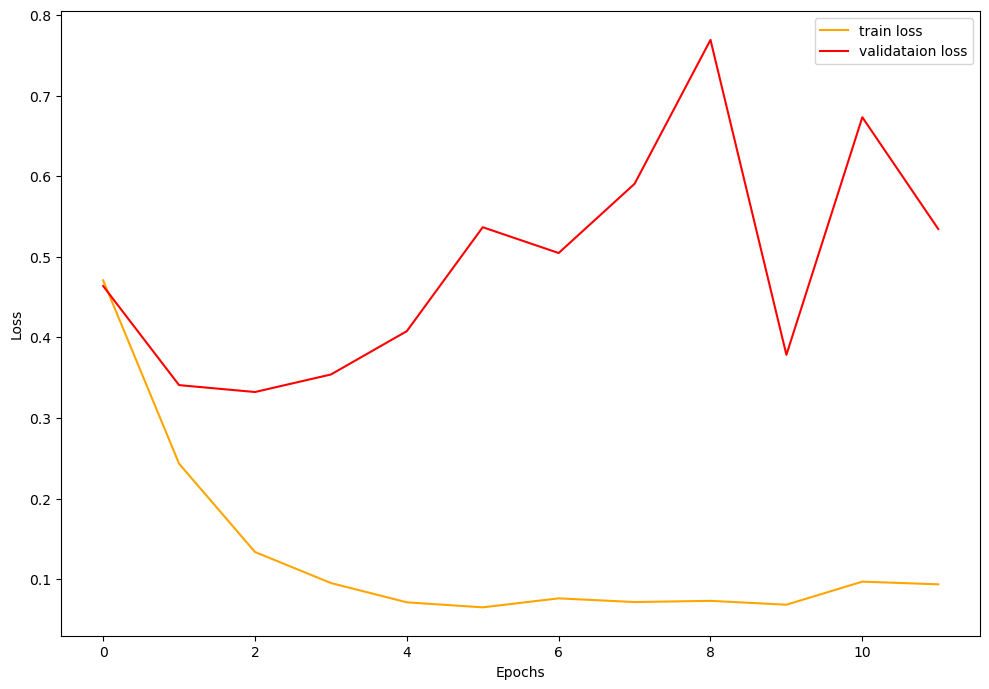

In [44]:
results, final_subset, weights=train(model=resnet_h3,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=resnet_h3_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=31 )

In [45]:
hybrid_loader3 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

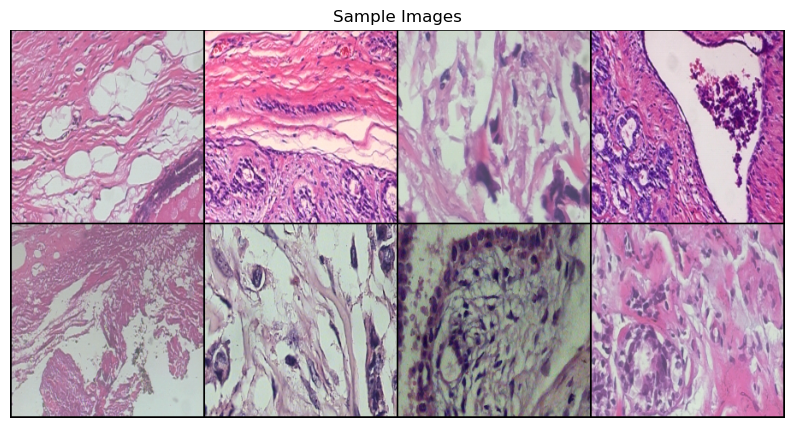

In [46]:
plot_images(hybrid_loader3, 8)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5815 | train_acc: 0.6955 | test_loss: 0.7488 | test_acc %: 56.25 | precision %: 7.29 | recall %:  9.72 | auc : 0.0665 | specificity %: 3.57 | f1: 0.0833 
Epoch: 2 | train_loss: 0.4290 | train_acc: 0.8087 | test_loss: 0.8406 | test_acc %: 50.00 | precision %: 6.94 | recall %:  6.94 | auc : 0.0615 | specificity %: 5.36 | f1: 0.0694 
Epoch: 3 | train_loss: 0.3840 | train_acc: 0.8416 | test_loss: 0.8583 | test_acc %: 43.75 | precision %: 6.25 | recall %:  5.56 | auc : 0.0546 | specificity %: 5.36 | f1: 0.0588 
Epoch: 4 | train_loss: 0.3406 | train_acc: 0.8619 | test_loss: 0.8323 | test_acc %: 56.25 | precision %: 7.50 | recall %:  8.33 | auc : 0.0685 | specificity %: 5.36 | f1: 0.0789 
Epoch: 5 | train_loss: 0.3137 | train_acc: 0.8760 | test_loss: 0.8593 | test_acc %: 43.75 | precision %: 6.25 | recall %:  5.56 | auc : 0.0546 | specificity %: 5.36 | f1: 0.0588 
Epoch: 6 | train_loss: 0.2964 | train_acc: 0.8767 | test_loss: 0.8690 | test_acc %: 43.75 | precision %: 

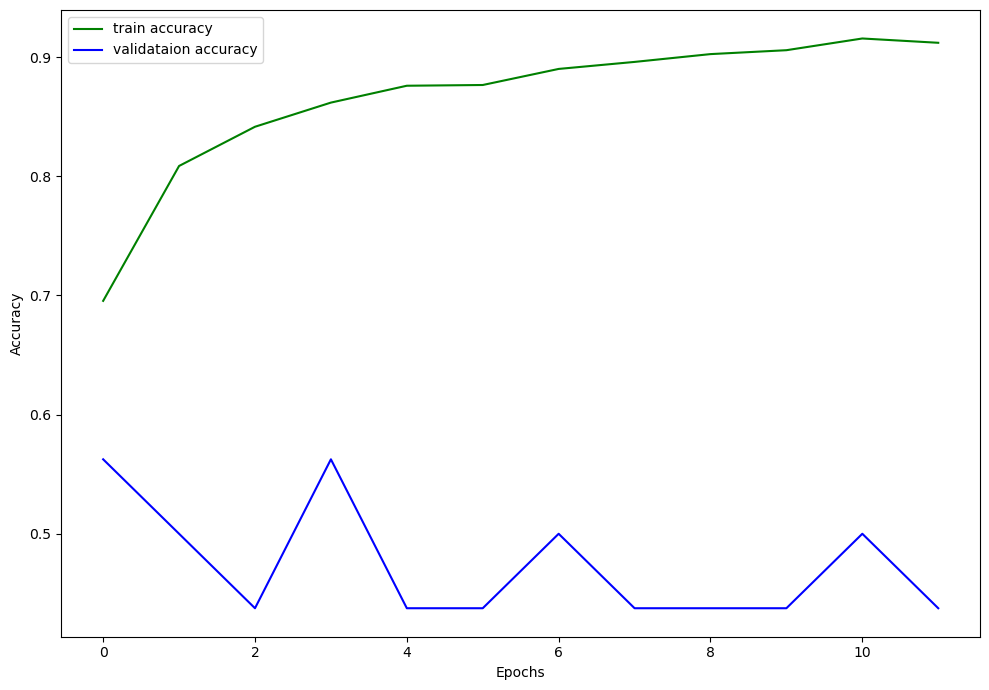

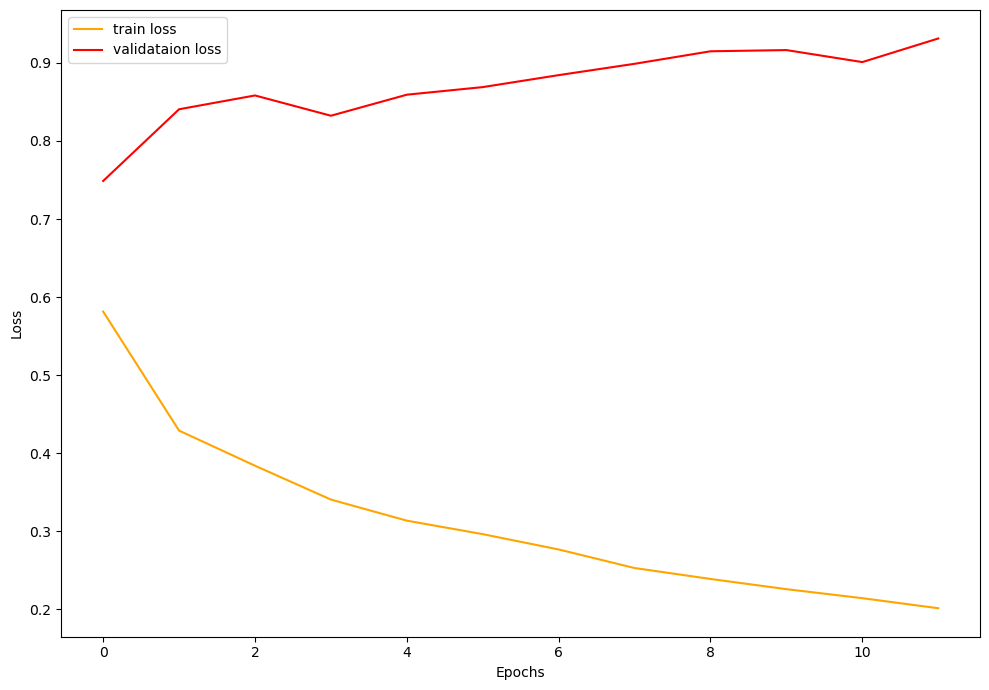

In [47]:
results, final_subset, weights=train(model=alexnet_h3,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader3,
              optimizer=alexnet_h3_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=32 )

---------------------------------------

# HYBRID 4 : ShuffleNet + AlexNet

In [48]:
shufflenet_h4 = ShuffleNet(num_classes=2)


shufflenet_h4_opt=torch.optim.SGD(params=shufflenet_h4.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

In [49]:
alexnet_h4 = AlexNet(num_classes=2)


alexnet_h4_opt=torch.optim.SGD(params=alexnet_h4.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6927 | train_acc: 0.5111 | test_loss: 0.6899 | test_acc %: 65.46 | precision %: 67.79 | recall %:  92.46 | auc : 0.5140 | specificity %: 10.34 | f1: 0.7815 
Epoch: 2 | train_loss: 0.6925 | train_acc: 0.5108 | test_loss: 0.6896 | test_acc %: 65.61 | precision %: 67.67 | recall %:  93.21 | auc : 0.5119 | specificity %: 9.16 | f1: 0.7835 
Epoch: 3 | train_loss: 0.6924 | train_acc: 0.5157 | test_loss: 0.6895 | test_acc %: 65.41 | precision %: 67.54 | recall %:  93.24 | auc : 0.5093 | specificity %: 8.62 | f1: 0.7827 
Epoch: 4 | train_loss: 0.6922 | train_acc: 0.5217 | test_loss: 0.6895 | test_acc %: 65.02 | precision %: 67.56 | recall %:  92.05 | auc : 0.5094 | specificity %: 9.82 | f1: 0.7786 
Epoch: 5 | train_loss: 0.6920 | train_acc: 0.5174 | test_loss: 0.6895 | test_acc %: 65.22 | precision %: 67.84 | recall %:  91.80 | auc : 0.5145 | specificity %: 11.11 | f1: 0.7793 
Epoch: 6 | train_loss: 0.6920 | train_acc: 0.5248 | test_loss: 0.6897 | test_acc %: 65.81 | p

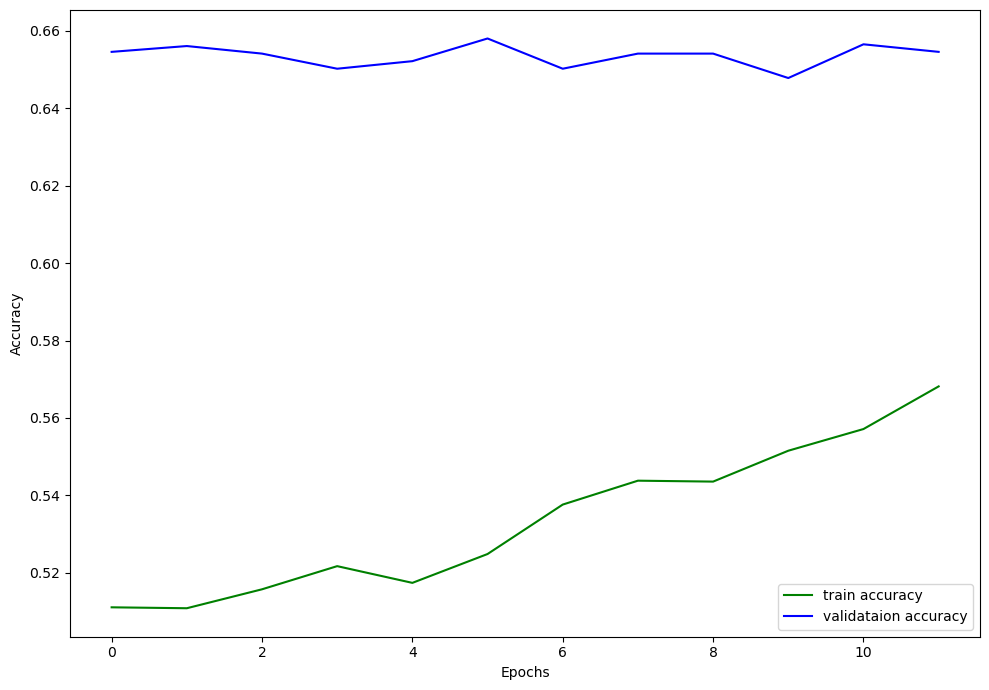

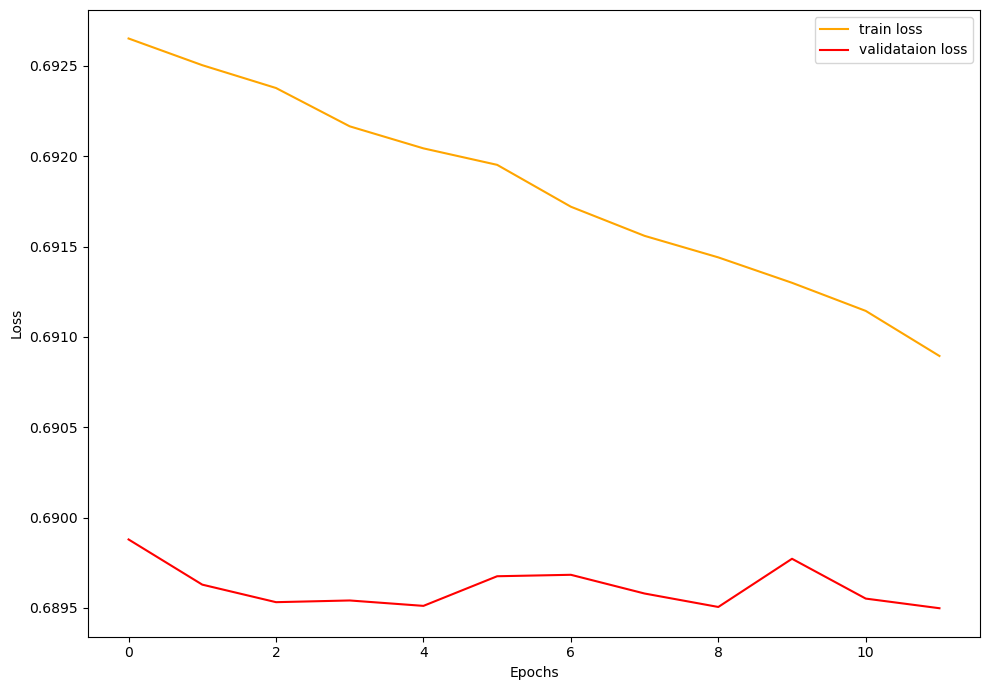

In [50]:
results, final_subset, weights=train(model=shufflenet_h4,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=shufflenet_h4_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device , num=41)

In [51]:
hybrid_loader4 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

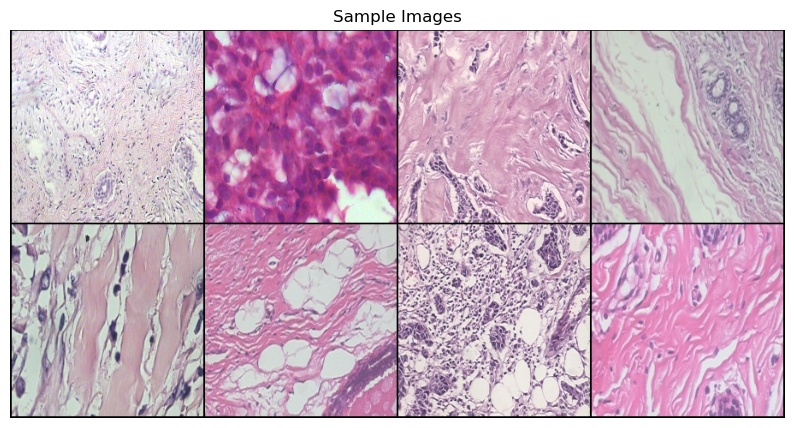

In [52]:
plot_images(hybrid_loader4, 8)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5773 | train_acc: 0.6767 | test_loss: 0.7908 | test_acc %: 62.50 | precision %: 7.69 | recall %:  11.11 | auc : 0.0734 | specificity %: 3.57 | f1: 0.0909 
Epoch: 2 | train_loss: 0.4392 | train_acc: 0.8107 | test_loss: 0.8311 | test_acc %: 50.00 | precision %: 6.94 | recall %:  6.94 | auc : 0.0615 | specificity %: 5.36 | f1: 0.0694 
Epoch: 3 | train_loss: 0.3711 | train_acc: 0.8560 | test_loss: 0.8717 | test_acc %: 56.25 | precision %: 7.29 | recall %:  9.72 | auc : 0.0665 | specificity %: 3.57 | f1: 0.0833 
Epoch: 4 | train_loss: 0.3340 | train_acc: 0.8665 | test_loss: 0.8492 | test_acc %: 43.75 | precision %: 6.25 | recall %:  6.94 | auc : 0.0526 | specificity %: 3.57 | f1: 0.0658 
Epoch: 5 | train_loss: 0.3057 | train_acc: 0.8758 | test_loss: 0.8389 | test_acc %: 50.00 | precision %: 6.94 | recall %:  6.94 | auc : 0.0615 | specificity %: 5.36 | f1: 0.0694 
Epoch: 6 | train_loss: 0.2834 | train_acc: 0.8830 | test_loss: 0.8200 | test_acc %: 50.00 | precision %:

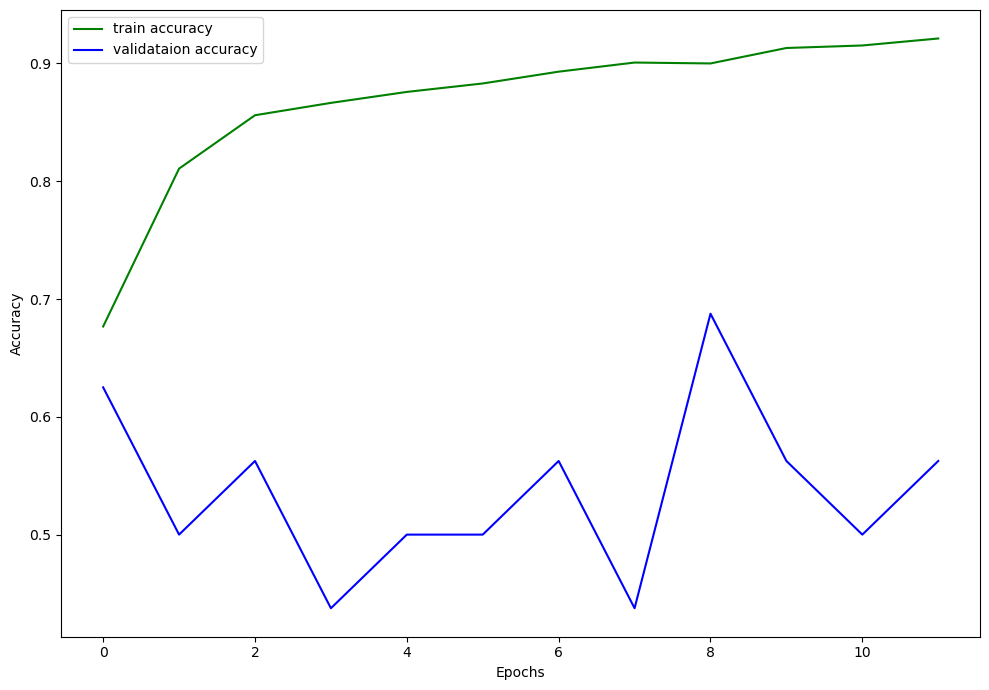

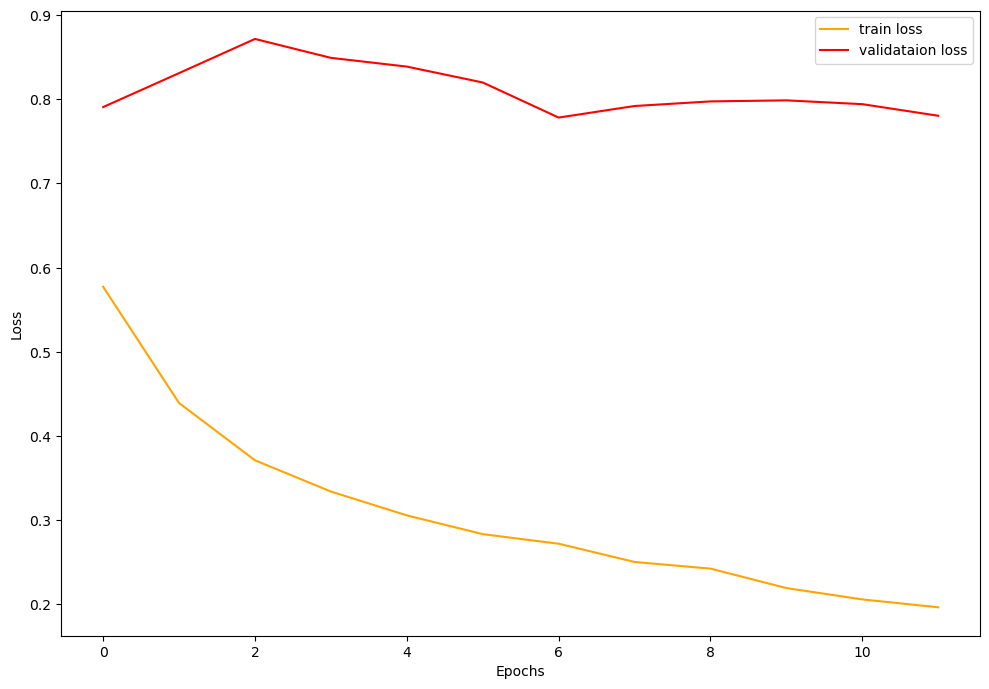

In [53]:
results, final_subset, weights=train(model=alexnet_h4,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader3,
              optimizer=alexnet_h4_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device , num=42)

--------------------------------------------------

# HYBRID 5 : ShuffleNet + ResNet18

In [54]:
shufflenet_h5 = ShuffleNet(num_classes=2)



shufflenet_h5_opt=torch.optim.SGD(params=shufflenet_h5.parameters(), 
                          lr=0.0001, 
                          momentum=0.9, 
                          weight_decay=0.0001)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
resnet_h5 = ResNet18(num_classes=2)
resnet_h5_opt=torch.optim.Adam(params=resnet_h5.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

# save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6930 | train_acc: 0.5040 | test_loss: 0.6889 | test_acc %: 64.77 | precision %: 68.04 | recall %:  89.34 | auc : 0.5180 | specificity %: 14.25 | f1: 0.7720 
Epoch: 2 | train_loss: 0.6929 | train_acc: 0.5106 | test_loss: 0.6888 | test_acc %: 64.72 | precision %: 68.18 | recall %:  88.66 | auc : 0.5208 | specificity %: 15.50 | f1: 0.7703 
Epoch: 3 | train_loss: 0.6927 | train_acc: 0.5150 | test_loss: 0.6888 | test_acc %: 65.22 | precision %: 68.88 | recall %:  87.66 | auc : 0.5335 | specificity %: 19.05 | f1: 0.7710 
Epoch: 4 | train_loss: 0.6925 | train_acc: 0.5160 | test_loss: 0.6890 | test_acc %: 65.76 | precision %: 69.58 | recall %:  86.61 | auc : 0.5472 | specificity %: 22.83 | f1: 0.7713 
Epoch: 5 | train_loss: 0.6924 | train_acc: 0.5173 | test_loss: 0.6888 | test_acc %: 65.81 | precision %: 69.83 | recall %:  86.16 | auc : 0.5505 | specificity %: 23.95 | f1: 0.7709 
Epoch: 6 | train_loss: 0.6923 | train_acc: 0.5322 | test_loss: 0.6888 | test_acc %: 66.44 

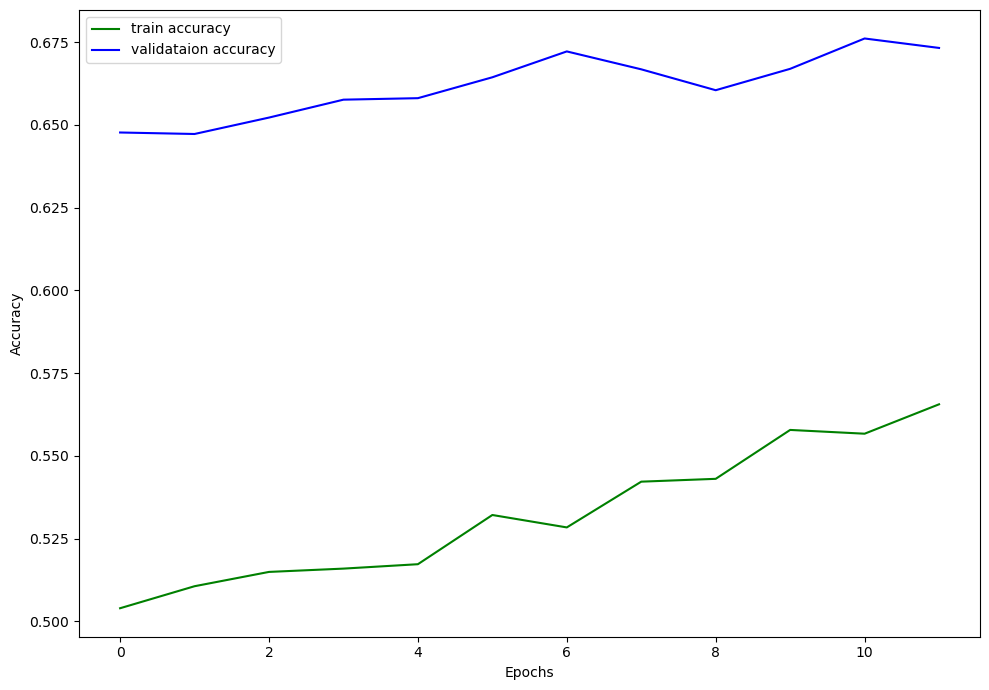

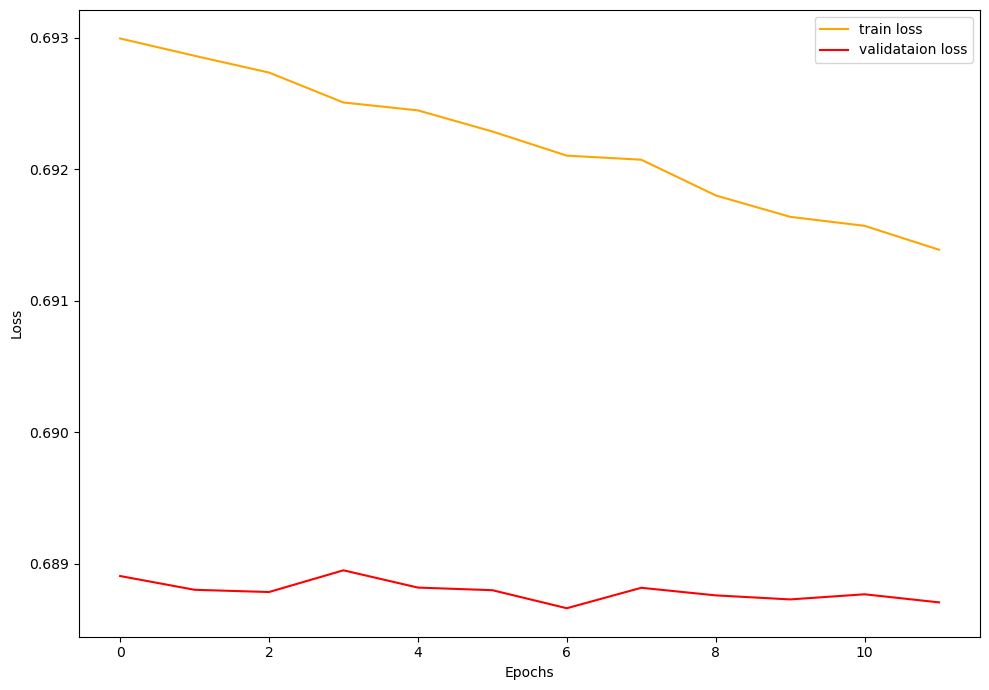

In [56]:
results, final_subset, weights=train(model=shufflenet_h5,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=shufflenet_h5_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device , num=51)

In [57]:
hybrid_loader5 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

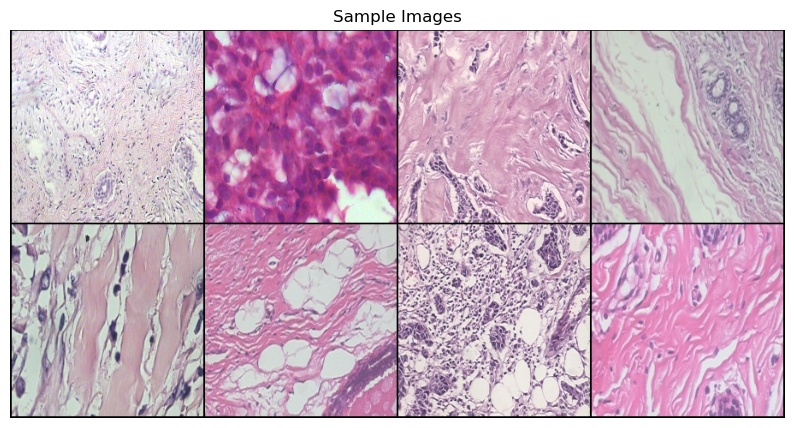

In [58]:
plot_images(hybrid_loader5, 8)

  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 | train_loss: 0.7870 | train_acc: 0.5017 | test_loss: 0.9093 | test_acc %: 33.91 | precision %: 56.25 | recall %:  1.83 | auc : 0.5059 | specificity %: 99.34 | f1: 0.0354 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 | train_loss: 0.7871 | train_acc: 0.4972 | test_loss: 0.9049 | test_acc %: 33.95 | precision %: 56.25 | recall %:  1.88 | auc : 0.5061 | specificity %: 99.34 | f1: 0.0362 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 | train_loss: 0.7871 | train_acc: 0.4996 | test_loss: 0.9061 | test_acc %: 33.95 | precision %: 50.00 | recall %:  1.89 | auc : 0.5062 | specificity %: 99.34 | f1: 0.0362 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 | train_loss: 0.7866 | train_acc: 0.4939 | test_loss: 0.9051 | test_acc %: 33.71 | precision %: 56.25 | recall %:  1.55 | auc : 0.5045 | specificity %: 99.34 | f1: 0.0301 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 | train_loss: 0.7865 | train_acc: 0.5004 | test_loss: 0.9033 | test_acc %: 33.95 | precision %: 50.00 | recall %:  1.89 | auc : 0.5062 | specificity %: 99.34 | f1: 0.0362 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 | train_loss: 0.7856 | train_acc: 0.4999 | test_loss: 0.9039 | test_acc %: 33.91 | precision %: 62.50 | recall %:  1.82 | auc : 0.5058 | specificity %: 99.34 | f1: 0.0352 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 | train_loss: 0.7875 | train_acc: 0.4977 | test_loss: 0.9069 | test_acc %: 33.91 | precision %: 62.50 | recall %:  1.82 | auc : 0.5058 | specificity %: 99.34 | f1: 0.0352 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 | train_loss: 0.7861 | train_acc: 0.4995 | test_loss: 0.9068 | test_acc %: 33.95 | precision %: 50.00 | recall %:  1.94 | auc : 0.5064 | specificity %: 99.34 | f1: 0.0371 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 | train_loss: 0.7874 | train_acc: 0.4981 | test_loss: 0.9040 | test_acc %: 34.10 | precision %: 68.75 | recall %:  2.12 | auc : 0.5073 | specificity %: 99.34 | f1: 0.0410 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Epoch: 10 | train_loss: 0.7871 | train_acc: 0.4966 | test_loss: 0.9048 | test_acc %: 33.76 | precision %: 43.75 | recall %:  1.62 | auc : 0.5048 | specificity %: 99.34 | f1: 0.0311 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11 | train_loss: 0.7862 | train_acc: 0.4988 | test_loss: 0.9050 | test_acc %: 33.71 | precision %: 50.00 | recall %:  1.51 | auc : 0.5043 | specificity %: 99.34 | f1: 0.0293 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12 | train_loss: 0.7871 | train_acc: 0.5013 | test_loss: 0.9046 | test_acc %: 34.34 | precision %: 68.75 | recall %:  2.47 | auc : 0.5091 | specificity %: 99.34 | f1: 0.0475 


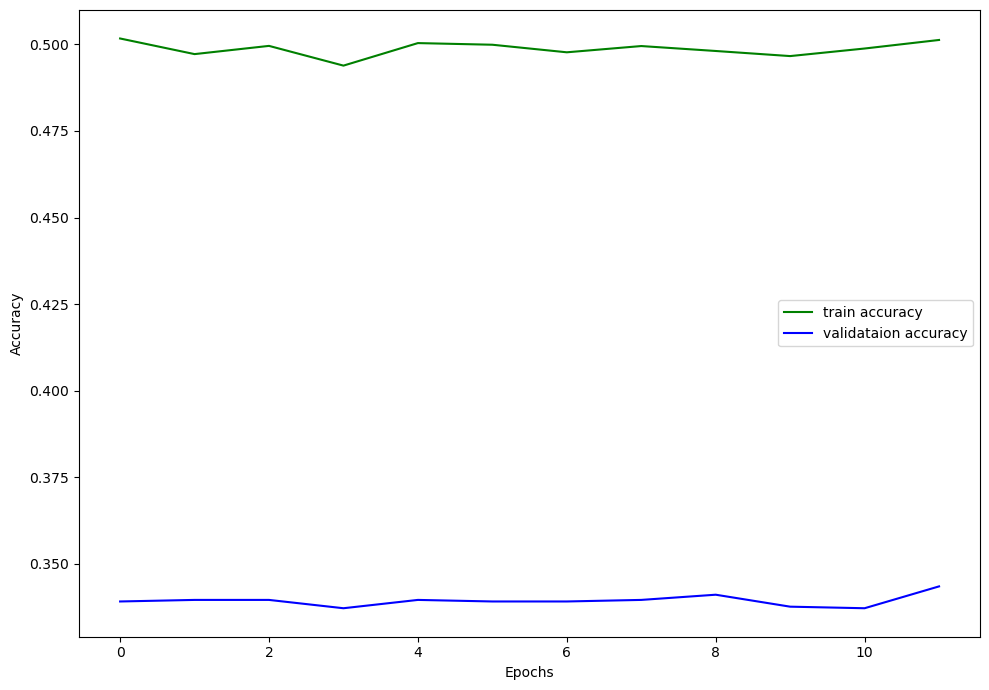

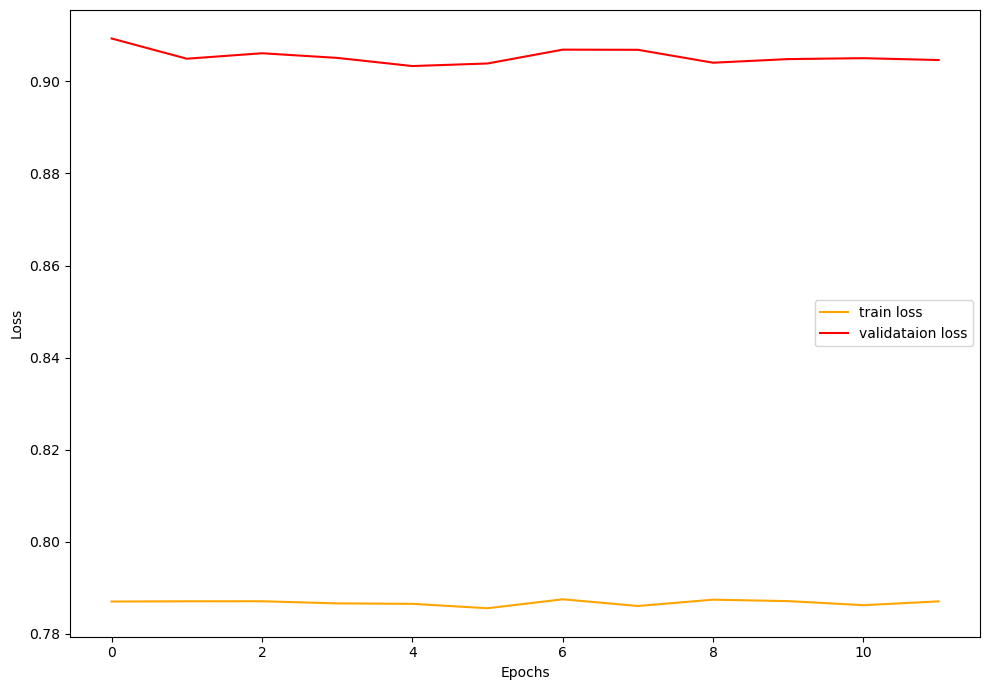

In [59]:
results, final_subset, weights=train(model=resnet_h5,
              train_dataloader=train_loader,
              test_dataloader=hybrid_loader5,
              optimizer=alexnet_h4_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, num=52 )

---------------------------------